## Note that %pip is a special IPython magic command that is recommended for use in Jupyter notebooks, as it can help ensure that the installed packages are available in the current Jupyter kernel.

In [89]:
import os
os.environ['IS_COLAB'] = 'False'
# %pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu -q
# %pip install sklearn -q
## Only need the libraries below in Collab
%pip install alpaca_trade_api -q
%pip install python-dotenv -q
%pip install ta -q


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [90]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ta  # Technical Analysis Library
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
from math import sqrt
from dotenv import load_dotenv
import time
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import requests

load_dotenv()

# Function to check if the notebook is running on Google Colab
def is_running_on_colab():
    return os.getenv('IS_COLAB') == 'True'
    from google.colab import userdata

# Load secrets based on environment
if is_running_on_colab():
    # Load from Colab secrets
    from google.colab import userdata
    ALPACA_API_KEY_ID = userdata.get('ALPACA_API_KEY')
    ALPACA_API_SECRET_KEY = userdata.get('ALPACA_API_SECRET')
    POLYGON_API_KEY = userdata.get('POLYGON_API_KEY')
else:
    # Load from local environment variables
    ALPACA_API_KEY_ID = os.getenv("ALPACA_API_KEY")
    ALPACA_API_SECRET_KEY = os.getenv("ALPACA_API_SECRET")
    POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")

target_stock = 'SRNE'
# target_stock = 'NVDA'

# Initialize Alpaca API
api = tradeapi.REST(ALPACA_API_KEY_ID, ALPACA_API_SECRET_KEY, 'https://paper-api.alpaca.markets')

# Fetch Data
def fetch_data(symbol, start_date, end_date):
    data = api.get_bars(symbol, TimeFrame.Minute, start_date, end_date, adjustment='raw').df

    # Add technical indicators and future close column
    data['close_future'] = data['close'].shift(-15)
    data['rsi'] = ta.momentum.rsi(data['close'])
    data['ema'] = ta.trend.ema_indicator(data['close'])
    data['cmf'] = ta.volume.chaikin_money_flow(data['high'], data['low'], data['close'], data['volume'])
    data['vwap'] = ta.volume.volume_weighted_average_price(data['high'], data['low'], data['close'], data['volume'])
    data['bollinger_high'] = ta.volatility.bollinger_hband(data['close'])
    data['bollinger_low'] = ta.volatility.bollinger_lband(data['close'])
    data['macd'] = ta.trend.macd(data['close'])
    ichimoku = ta.trend.IchimokuIndicator(data['high'], data['low'])
    data['ichimoku_a'] = ichimoku.ichimoku_a()
    data['ichimoku_b'] = ichimoku.ichimoku_b()
    data['ichimoku_base'] = ichimoku.ichimoku_base_line()
    data['ichimoku_conversion'] = ichimoku.ichimoku_conversion_line()
    data['stoch'] = ta.momentum.stoch(data['high'], data['low'], data['close'])

    data.dropna(inplace=True)
    return data

train_data = fetch_data(target_stock, '2020-01-01', '2020-07-01')
test_data = fetch_data(target_stock, '2020-07-02', '2020-07-03')

# train_data = fetch_data(target_stock, '2019-12-18', '2019-12-31')
# test_data = fetch_data(target_stock, '2020-01-01', '2023-12-26')

# train_data = fetch_data(target_stock, '2023-10-01', '2023-11-01')
# test_data = fetch_data(target_stock, '2023-11-02', '2023-12-26')

# Assuming train_data and test_data are pandas DataFrames already defined and have a 'close' column.

# Print the columns of the DataFrame to verify its structure
# print(f"Number of Train Data: {train_data.columns}")
# print(os.getenv("POLYGON_API_KEY"))
# !echo $POLYGON_API_KEY


# def fetch_polygon_data(symbol, start_date, end_date, apiKey):
#     url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start_date}/{end_date}?apiKey={apiKey}"
    
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         df = pd.DataFrame(data['results'])
#         df.rename(columns={'t': 'timestamp', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}, inplace=True)
#         df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        
#         # Add technical indicators
#         df['close_future'] = df['close'].shift(-15)
#         df['rsi'] = ta.momentum.rsi(df['close'])
#         df['ema'] = ta.trend.ema_indicator(df['close'])
#         df['cmf'] = ta.volume.chaikin_money_flow(df['high'], df['low'], df['close'], df['volume'])
#         df['vwap'] = ta.volume.volume_weighted_average_price(df['high'], df['low'], df['close'], df['volume'])
#         df['bollinger_high'] = ta.volatility.bollinger_hband(df['close'])
#         df['bollinger_low'] = ta.volatility.bollinger_lband(df['close'])
#         df['macd'] = ta.trend.macd(df['close'])
#         ichimoku = ta.trend.IchimokuIndicator(df['high'], df['low'])
#         df['ichimoku_a'] = ichimoku.ichimoku_a()
#         df['ichimoku_b'] = ichimoku.ichimoku_b()
#         df['ichimoku_base'] = ichimoku.ichimoku_base_line()
#         df['ichimoku_conversion'] = ichimoku.ichimoku_conversion_line()
#         df['stoch'] = ta.momentum.stoch(df['high'], df['low'], df['close'])

#         df.dropna(inplace=True)
#         return df
#     else:
#         print(f"Failed to fetch data: {response.status_code}")
#         return None

# # Example usage
# train_data = fetch_polygon_data(target_stock, '2020-06-01', '2020-07-01', POLYGON_API_KEY)
# test_data = fetch_polygon_data(target_stock, '2020-07-02', '2020-07-03', POLYGON_API_KEY)

In [91]:
# Print the last 5 rows of test_data to verify its structure
test_data.head(20)
# print columns of test_data
# print(f"Number of Test Data: {test_data.columns}")

,close,high,low,trade_count,open,volume,vwap,close_future,rsi,ema,cmf,bollinger_high,bollinger_low,macd,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,stoch
timestamp,,,,,,,,,,,,,,,,,,,
2020-07-02 09:30:00+00:00,7.09,7.09,7.09,2,7.09,996,7.075500,7.15,40.443859,7.127226,-0.268730,7.305442,7.013558,-0.047512,7.1375,7.165,7.165,7.110,38.888889
2020-07-02 09:31:00+00:00,7.06,7.06,7.06,2,7.06,200,7.074378,7.15,37.954078,7.116884,-0.273290,7.303348,7.001652,-0.049356,7.1350,7.165,7.160,7.110,22.222222
2020-07-02 09:41:00+00:00,7.06,7.06,7.06,1,7.06,300,7.072292,7.15,37.954078,7.108133,-0.268775,7.282972,6.999028,-0.050238,7.1350,7.165,7.160,7.110,22.222222
2020-07-02 09:43:00+00:00,7.06,7.06,7.06,3,7.06,1400,7.070387,7.14,37.954078,7.100728,-0.308923,7.254841,7.003159,-0.050356,7.1300,7.165,7.160,7.100,22.222222
2020-07-02 09:45:00+00:00,7.05,7.06,7.05,4,7.06,368,7.068990,7.10,37.005639,7.092923,-0.341213,7.223414,7.010586,-0.050672,7.1225,7.165,7.160,7.085,16.666667
2020-07-02 09:54:00+00:00,7.09,7.09,7.09,2,7.09,139,7.067386,7.10,43.127684,7.092474,-0.342878,7.208959,7.013041,-0.047152,7.1225,7.165,7.160,7.085,38.888889
2020-07-02 09:57:00+00:00,7.05,7.05,7.05,3,7.05,156,7.066396,7.20,39.041601,7.085939,-0.361223,7.205679,7.006321,-0.047048,7.1225,7.165,7.160,7.085,16.666667
2020-07-02 09:59:00+00:00,7.03,7.03,7.03,2,7.03,828,7.058203,7.29,37.146537,7.077333,-0.340346,7.202762,6.997238,-0.048025,7.1075,7.165,7.160,7.055,5.555556
2020-07-02 10:01:00+00:00,7.04,7.04,7.04,1,7.04,100,7.052527,7.26,38.747477,7.071590,-0.343207,7.197742,6.991258,-0.047446,7.1100,7.165,7.160,7.060,12.500000


## Feature Selection
### Feature selection involves choosing only the most significant features that contribute to the prediction. Calculate the correlation matrix and drop features that are highly correlated with others.

In [92]:
# Exclude 'close_future' and close when calculating the correlation matrix
features = train_data.drop(columns=['close_future','close'])
correlation_matrix = features.corr()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]


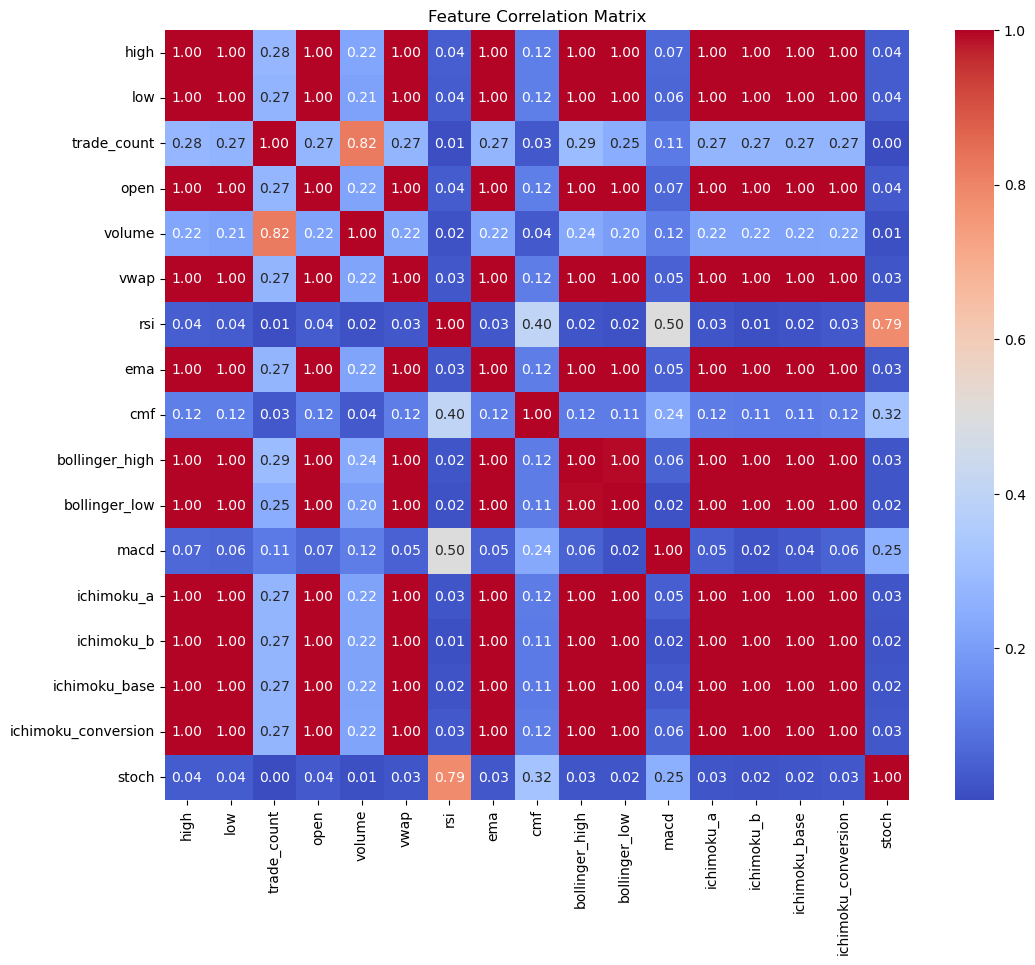

In [93]:
# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [94]:
# Drop highly correlated features
train_data = train_data.drop(columns=high_correlation_features)
test_data = test_data.drop(columns=high_correlation_features)

In [95]:
#print the last 10 rows of the train_data DataFrame
print(train_data.tail(10))

                           close  high  trade_count  volume  close_future  \
timestamp                                                                   
2020-07-01 23:35:00+00:00   7.33  7.33           15    6000          7.33   
2020-07-01 23:36:00+00:00   7.34  7.34            8    4009          7.35   
2020-07-01 23:37:00+00:00   7.35  7.35            9    2037          7.38   
2020-07-01 23:38:00+00:00   7.34  7.35           16    2122          7.38   
2020-07-01 23:39:00+00:00   7.35  7.35           12    6570          7.31   
2020-07-01 23:40:00+00:00   7.33  7.33           11    4301          7.33   
2020-07-01 23:41:00+00:00   7.33  7.35           16    4209          7.35   
2020-07-01 23:42:00+00:00   7.31  7.35           10    4115          7.33   
2020-07-01 23:43:00+00:00   7.35  7.35            7     908          7.33   
2020-07-01 23:44:00+00:00   7.35  7.35           14    3374          7.30   

                                 rsi       cmf      macd       stoch  
time

Calculated NUM_FEATURES: 8
Using device: mps
Processing window 1/46
Window 1, Epoch 0/100, Loss: 0.147428, Iterations/s: 3.33
Processing window 2/46
Window 2, Epoch 0/100, Loss: 0.000350, Iterations/s: 17.78
Processing window 3/46
Window 3, Epoch 0/100, Loss: 0.000208, Iterations/s: 16.65
Processing window 4/46
Window 4, Epoch 0/100, Loss: 0.000176, Iterations/s: 17.82
Processing window 5/46
Window 5, Epoch 0/100, Loss: 0.000156, Iterations/s: 18.01
Processing window 6/46
Window 6, Epoch 0/100, Loss: 0.000139, Iterations/s: 18.54
Processing window 7/46
Window 7, Epoch 0/100, Loss: 0.000123, Iterations/s: 18.55
Processing window 8/46
Window 8, Epoch 0/100, Loss: 0.000111, Iterations/s: 17.72
Processing window 9/46
Window 9, Epoch 0/100, Loss: 0.000104, Iterations/s: 18.09
Processing window 10/46
Window 10, Epoch 0/100, Loss: 0.000100, Iterations/s: 18.46
Processing window 11/46
Window 11, Epoch 0/100, Loss: 0.000099, Iterations/s: 18.05
Processing window 12/46
Window 12, Epoch 0/100, Lo

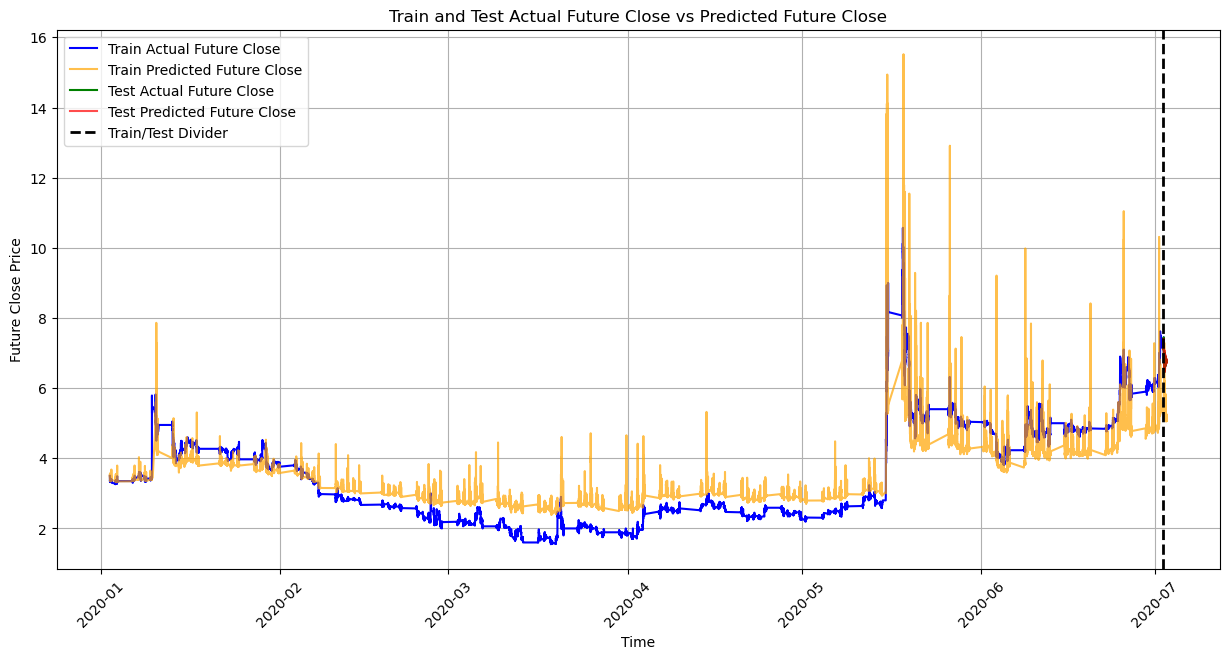

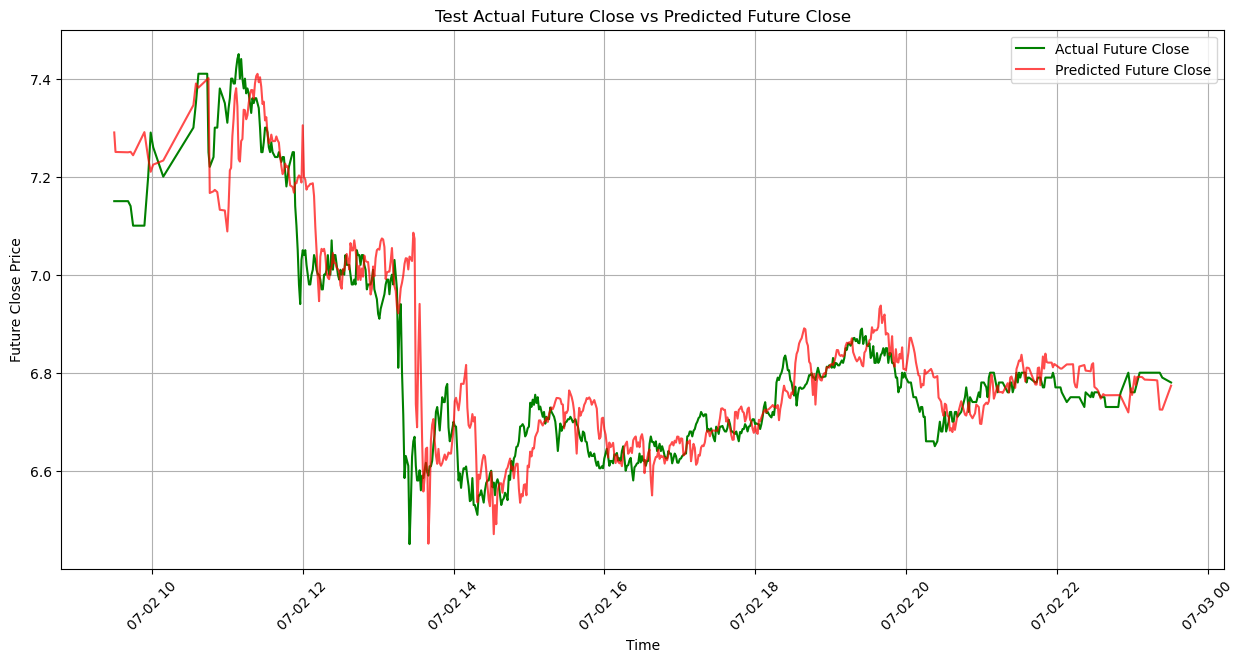

In [96]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time

# Define the window size and the number of features
WINDOW_SIZE = 15
NUM_FEATURES = len(train_data.columns) - 1  # Adjust based on the actual number of features

# Initialize the LSTM model
hidden_size = 50
num_layers = 3
output_size = 1
dropout_probability = 0.5  # Choose a value for dropout

# Training parameters
n_epochs = 100
learning_rate = 0.001

# Now print NUM_FEATURES to verify it's correct
print(f"Calculated NUM_FEATURES: {NUM_FEATURES}")

# Standardize the training data and normalize the target variable
ss = StandardScaler()
mm = MinMaxScaler()

# Make sure 'ds' column is created before running the rolling window loop
train_data['ds'] = train_data.index
test_data['ds'] = test_data.index

# LSTM model definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Training function
def train_model(model, optimiser, loss_fn, X_train, y_train, n_epochs, window_num):
    y_train = y_train.view(-1, 1)
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        optimiser.zero_grad()
        outputs = model(X_train)
        if outputs.shape != y_train.shape:
            outputs = outputs.view(*y_train.shape)

        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimiser.step()
        end_time = time.time()

        iteration_time = end_time - start_time
        iterations_per_second = 1 / iteration_time

        if epoch % 100 == 0:
            print(f'Window {window_num}, Epoch {epoch}/{n_epochs}, Loss: {loss.item():.6f}, Iterations/s: {iterations_per_second:.2f}')

# Select the device for training
# Check for available devices in order of preference: CUDA, MPS, then CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Initialize the LSTM model
model = LSTM(NUM_FEATURES, hidden_size, num_layers, output_size).to(device)

# Define the loss function and the optimizer
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# Rolling window prediction and training
predictions = []

for i in range(0, len(test_data), WINDOW_SIZE):
    window_num = i // WINDOW_SIZE + 1
    print(f"Processing window {window_num}/{len(test_data)//WINDOW_SIZE + (len(test_data) % WINDOW_SIZE > 0)}")

    end_idx = i + WINDOW_SIZE

    # Prepare training data
    train_window = train_data.copy()
    # Drop non-numeric columns
    train_window_numeric = train_window.select_dtypes(include=[np.number])

    X_train_scaled = ss.fit_transform(train_window_numeric.drop(columns=['close_future']))
    y_train_scaled = mm.fit_transform(train_window_numeric[['close_future']])

    # Convert to tensors
    X_train_tensors = Variable(torch.Tensor(X_train_scaled)).to(device)
    y_train_tensors = Variable(torch.Tensor(y_train_scaled)).to(device)

    # Reshape for LSTM input
    X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    y_train_tensors_final = torch.reshape(y_train_tensors, (y_train_tensors.shape[0], 1, y_train_tensors.shape[1]))

    # Train the model
    train_model(model, optimiser, loss_fn, X_train_tensors_final, y_train_tensors_final, n_epochs, window_num)

    # Prepare test data
    test_window = test_data.iloc[i:end_idx]
    # Drop non-numeric columns
    test_window_numeric = test_window.select_dtypes(include=[np.number])

    X_test_scaled = ss.transform(test_window_numeric.drop(columns=['close_future']))
    X_test_tensors = Variable(torch.Tensor(X_test_scaled)).to(device)
    X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

    # Predict on the next window of test data
    model.eval()
    with torch.no_grad():
        test_prediction = model(X_test_tensors_final)
        test_prediction = test_prediction.cpu().data.numpy()
        test_prediction = mm.inverse_transform(test_prediction)
        predictions.extend(test_prediction.flatten().tolist())

    # Add the window to the training data for the next iteration
    train_data = pd.concat([train_data, test_window])

# Function to run predictions on training data
def predict_model(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i, (X_batch, _) in enumerate(data_loader):
            X_batch = X_batch.view(X_batch.size(0), 1, -1).to(device)
            y_pred = model(X_batch)
            y_pred = y_pred.cpu().data.numpy()
            y_pred = mm.inverse_transform(y_pred.reshape(-1, 1))
            predictions.extend(y_pred.flatten().tolist())
    return predictions

# Convert the training dataset to tensors
train_data_scaled = ss.fit_transform(train_data.select_dtypes(include=[np.number]).drop(columns=['close']))
train_targets_scaled = mm.fit_transform(train_data.select_dtypes(include=[np.number])[['close']])

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(train_data_scaled),
    torch.Tensor(train_targets_scaled)
)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

# Get predictions on training data
train_predictions = predict_model(model, train_loader)

# After generating predictions for the test set
test_predictions = predictions[:len(test_data)]  # assuming 'predictions' contains your test set predictions

# Calculate error metrics for the predictions
actuals = test_data['close_future'][:len(predictions)]
mae = mean_absolute_error(actuals, predictions)
rmse = sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

# Plotting the actual vs predicted values
plt.figure(figsize=(15, 7))
plt.xticks(rotation=45)
plt.plot(train_data.index, train_data['close_future'], label='Train Actual Future Close', color='blue')
plt.plot(train_data.index[:len(train_predictions)], train_predictions, label='Train Predicted Future Close', color='orange', alpha=0.7)
plt.plot(test_data.index, test_data['close_future'], label='Test Actual Future Close', color='green')
plt.plot(test_data.index[:len(predictions)], predictions, label='Test Predicted Future Close', color='red', alpha=0.7)
plt.axvline(x=test_data.index[0], color='black', linestyle='--', linewidth=2, label='Train/Test Divider')
plt.title('Train and Test Actual Future Close vs Predicted Future Close')
plt.xlabel('Time')
plt.ylabel('Future Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Creating a ledger DataFrame
ledger = pd.DataFrame({
    'Timestamp': train_data.index.tolist() + test_data.index.tolist(),
    'Actual Future Close': train_data['close_future'].tolist() + test_data['close_future'][:len(predictions)].tolist(),
    'Predicted Future Close': train_predictions + predictions,
})

plt.figure(figsize=(15, 7))
plt.xticks(rotation=45)
plt.plot(test_data.index, test_data['close_future'], label='Actual Future Close', color='green')
plt.plot(test_data.index[:len(predictions)], predictions, label='Predicted Future Close', color='red', alpha=0.7)
plt.title('Test Actual Future Close vs Predicted Future Close')
plt.xlabel('Time')
plt.ylabel('Future Close Price')
plt.legend()
plt.grid(True)
plt.show()
